# TensorBoard Visualizations

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

## Get the data

In [2]:
housing = fetch_california_housing()

### Create train, validation and test sets

In [3]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

In [5]:
X_train.shape

(11610, 8)

In [6]:
X_test.shape

(5160, 8)

In [7]:
X_valid.shape

(3870, 8)

### Scale the data

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_valid = scaler.transform(X_valid)

In [9]:
X_train.shape[1:]

(8,)

### Split the data further into different subsets

In [10]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]

In [11]:
X_train_A.shape

(11610, 5)

In [12]:
X_train_B.shape

(11610, 6)

## Create the model

We create a model with two input layers. In our scenario, we only feed different subsets of features into the two input layers. Input layer A is directly connected to a concatenate layer (the *wide* part), while input layer B is fed into two subsequent hidden layers 1 and 2 (the *deep* part), with the latter connecting to the concatenate layer as well. From the concatenate layer, the main output is generated. As an additional output, the auxiliary output layer is generated from hidden layer 2.<br>
The auxiliary output layer can be used to make sure that the deep part of the network trains some useful features on its own, without relying on the wide part.

In [13]:
input_A = keras.layers.Input(shape=X_train_A.shape[1:], name='wide_input')
input_B = keras.layers.Input(shape=X_train_B.shape[1:], name='deep_input')
hidden1 = keras.layers.Dense(30, activation='relu', name='hidden_1')(input_B)
hidden2 = keras.layers.Dense(30, activation='relu', name='hidden_2')(hidden1)
concat = keras.layers.Concatenate(name='wide_concat')([input_A, hidden2])
output = keras.layers.Dense(1, name='main_output')(concat)
aux_output = keras.layers.Dense(1, name='aux_output')(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

In [14]:
model.compile(
    loss=['mse', 'mse'],
    loss_weights=[0.9, 0.1],
    optimizer=keras.optimizers.SGD(lr=5e-2),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mean_absolute_percentage_error']
)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
deep_input (InputLayer)         [(None, 6)]          0                                            
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 30)           210         deep_input[0][0]                 
__________________________________________________________________________________________________
wide_input (InputLayer)         [(None, 5)]          0                                            
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 30)           930         hidden_1[0][0]                   
______________________________________________________________________________________________

## Create the log file

In [16]:
root_logdir = os.path.join(os.curdir, 'my_logs')

def get_run_logdir():
    return os.path.join(root_logdir, time.strftime('run_%Y_%m_%d-%H_%M_%S'))

run_logdir = get_run_logdir()

## Create the model callbacks

In [17]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

## Train the model

In [18]:
history = model.fit(
    {'wide_input': X_train_A, 'deep_input': X_train_B},
    {'main_output': y_train, 'aux_output': y_train},
    epochs=150,
    validation_data=(
        {'wide_input': X_valid_A, 'deep_input': X_valid_B},
        {'main_output': y_valid, 'aux_output': y_valid}
    ),
    callbacks=[tensorboard_cb]
)

Epoch 1/150
363/363 [==============================] - 2s 4ms/step - loss: 0.9365 - main_output_loss: 0.8387 - aux_output_loss: 1.8162 - main_output_root_mean_squared_error: 0.8987 - main_output_mean_absolute_percentage_error: 36.3569 - aux_output_root_mean_squared_error: 1.3155 - aux_output_mean_absolute_percentage_error: 54.6730 - val_loss: 0.5304 - val_main_output_loss: 0.4964 - val_aux_output_loss: 0.8363 - val_main_output_root_mean_squared_error: 0.7046 - val_main_output_mean_absolute_percentage_error: 28.0260 - val_aux_output_root_mean_squared_error: 0.9145 - val_aux_output_mean_absolute_percentage_error: 40.3851
Epoch 2/150
363/363 [==============================] - 0s 768us/step - loss: 0.5797 - main_output_loss: 0.5565 - aux_output_loss: 0.7886 - main_output_root_mean_squared_error: 0.7454 - main_output_mean_absolute_percentage_error: 30.1362 - aux_output_root_mean_squared_error: 0.8879 - aux_output_mean_absolute_percentage_error: 39.8491 - val_loss: 0.4588 - val_main_output_l

363/363 [==============================] - 0s 746us/step - loss: 0.3693 - main_output_loss: 0.3611 - aux_output_loss: 0.4432 - main_output_root_mean_squared_error: 0.6007 - main_output_mean_absolute_percentage_error: 23.5728 - aux_output_root_mean_squared_error: 0.6655 - aux_output_mean_absolute_percentage_error: 27.8729 - val_loss: 0.4128 - val_main_output_loss: 0.4070 - val_aux_output_loss: 0.4657 - val_main_output_root_mean_squared_error: 0.6379 - val_main_output_mean_absolute_percentage_error: 21.7864 - val_aux_output_root_mean_squared_error: 0.6824 - val_aux_output_mean_absolute_percentage_error: 25.7912
Epoch 15/150
363/363 [==============================] - 0s 743us/step - loss: 0.3575 - main_output_loss: 0.3503 - aux_output_loss: 0.4224 - main_output_root_mean_squared_error: 0.5918 - main_output_mean_absolute_percentage_error: 23.0019 - aux_output_root_mean_squared_error: 0.6498 - aux_output_mean_absolute_percentage_error: 27.3162 - val_loss: 0.3726 - val_main_output_loss: 0.36

363/363 [==============================] - 0s 744us/step - loss: 0.3357 - main_output_loss: 0.3297 - aux_output_loss: 0.3895 - main_output_root_mean_squared_error: 0.5740 - main_output_mean_absolute_percentage_error: 22.0045 - aux_output_root_mean_squared_error: 0.6238 - aux_output_mean_absolute_percentage_error: 25.4475 - val_loss: 0.3299 - val_main_output_loss: 0.3230 - val_aux_output_loss: 0.3923 - val_main_output_root_mean_squared_error: 0.5683 - val_main_output_mean_absolute_percentage_error: 21.8508 - val_aux_output_root_mean_squared_error: 0.6263 - val_aux_output_mean_absolute_percentage_error: 24.9505
Epoch 28/150
363/363 [==============================] - 0s 743us/step - loss: 0.3311 - main_output_loss: 0.3244 - aux_output_loss: 0.3909 - main_output_root_mean_squared_error: 0.5694 - main_output_mean_absolute_percentage_error: 21.8261 - aux_output_root_mean_squared_error: 0.6251 - aux_output_mean_absolute_percentage_error: 25.3643 - val_loss: 0.3423 - val_main_output_loss: 0.33

363/363 [==============================] - 0s 769us/step - loss: 0.3152 - main_output_loss: 0.3101 - aux_output_loss: 0.3609 - main_output_root_mean_squared_error: 0.5568 - main_output_mean_absolute_percentage_error: 21.7367 - aux_output_root_mean_squared_error: 0.6007 - aux_output_mean_absolute_percentage_error: 24.3184 - val_loss: 0.3281 - val_main_output_loss: 0.3218 - val_aux_output_loss: 0.3843 - val_main_output_root_mean_squared_error: 0.5673 - val_main_output_mean_absolute_percentage_error: 21.5208 - val_aux_output_root_mean_squared_error: 0.6199 - val_aux_output_mean_absolute_percentage_error: 24.1368
Epoch 41/150
363/363 [==============================] - 0s 798us/step - loss: 0.3211 - main_output_loss: 0.3153 - aux_output_loss: 0.3739 - main_output_root_mean_squared_error: 0.5614 - main_output_mean_absolute_percentage_error: 21.5017 - aux_output_root_mean_squared_error: 0.6113 - aux_output_mean_absolute_percentage_error: 24.5247 - val_loss: 0.3192 - val_main_output_loss: 0.31

363/363 [==============================] - 0s 754us/step - loss: 0.3085 - main_output_loss: 0.3023 - aux_output_loss: 0.3640 - main_output_root_mean_squared_error: 0.5497 - main_output_mean_absolute_percentage_error: 21.1194 - aux_output_root_mean_squared_error: 0.6032 - aux_output_mean_absolute_percentage_error: 24.2958 - val_loss: 0.3375 - val_main_output_loss: 0.3318 - val_aux_output_loss: 0.3882 - val_main_output_root_mean_squared_error: 0.5760 - val_main_output_mean_absolute_percentage_error: 21.5667 - val_aux_output_root_mean_squared_error: 0.6230 - val_aux_output_mean_absolute_percentage_error: 24.6240
Epoch 54/150
363/363 [==============================] - 0s 776us/step - loss: 0.3117 - main_output_loss: 0.3063 - aux_output_loss: 0.3598 - main_output_root_mean_squared_error: 0.5533 - main_output_mean_absolute_percentage_error: 20.9646 - aux_output_root_mean_squared_error: 0.5998 - aux_output_mean_absolute_percentage_error: 23.7220 - val_loss: 0.3487 - val_main_output_loss: 0.34

363/363 [==============================] - 0s 772us/step - loss: 0.3199 - main_output_loss: 0.3155 - aux_output_loss: 0.3597 - main_output_root_mean_squared_error: 0.5614 - main_output_mean_absolute_percentage_error: 21.2050 - aux_output_root_mean_squared_error: 0.5997 - aux_output_mean_absolute_percentage_error: 23.5142 - val_loss: 0.3205 - val_main_output_loss: 0.3153 - val_aux_output_loss: 0.3674 - val_main_output_root_mean_squared_error: 0.5615 - val_main_output_mean_absolute_percentage_error: 21.6396 - val_aux_output_root_mean_squared_error: 0.6062 - val_aux_output_mean_absolute_percentage_error: 24.2223
Epoch 67/150
363/363 [==============================] - 0s 741us/step - loss: 0.3080 - main_output_loss: 0.3032 - aux_output_loss: 0.3517 - main_output_root_mean_squared_error: 0.5504 - main_output_mean_absolute_percentage_error: 20.8431 - aux_output_root_mean_squared_error: 0.5928 - aux_output_mean_absolute_percentage_error: 23.3677 - val_loss: 0.3156 - val_main_output_loss: 0.31

363/363 [==============================] - 0s 732us/step - loss: 0.3050 - main_output_loss: 0.3008 - aux_output_loss: 0.3427 - main_output_root_mean_squared_error: 0.5483 - main_output_mean_absolute_percentage_error: 21.2353 - aux_output_root_mean_squared_error: 0.5854 - aux_output_mean_absolute_percentage_error: 23.4201 - val_loss: 0.3154 - val_main_output_loss: 0.3101 - val_aux_output_loss: 0.3627 - val_main_output_root_mean_squared_error: 0.5569 - val_main_output_mean_absolute_percentage_error: 20.4539 - val_aux_output_root_mean_squared_error: 0.6023 - val_aux_output_mean_absolute_percentage_error: 22.9735
Epoch 80/150
363/363 [==============================] - 0s 767us/step - loss: 0.2868 - main_output_loss: 0.2821 - aux_output_loss: 0.3292 - main_output_root_mean_squared_error: 0.5307 - main_output_mean_absolute_percentage_error: 20.2673 - aux_output_root_mean_squared_error: 0.5733 - aux_output_mean_absolute_percentage_error: 22.6307 - val_loss: 0.3247 - val_main_output_loss: 0.31

363/363 [==============================] - 0s 736us/step - loss: 0.2976 - main_output_loss: 0.2936 - aux_output_loss: 0.3331 - main_output_root_mean_squared_error: 0.5418 - main_output_mean_absolute_percentage_error: 20.9151 - aux_output_root_mean_squared_error: 0.5771 - aux_output_mean_absolute_percentage_error: 22.9583 - val_loss: 0.3424 - val_main_output_loss: 0.3384 - val_aux_output_loss: 0.3779 - val_main_output_root_mean_squared_error: 0.5818 - val_main_output_mean_absolute_percentage_error: 22.8289 - val_aux_output_root_mean_squared_error: 0.6148 - val_aux_output_mean_absolute_percentage_error: 24.2739
Epoch 93/150
363/363 [==============================] - 0s 730us/step - loss: 0.4236 - main_output_loss: 0.4311 - aux_output_loss: 0.3560 - main_output_root_mean_squared_error: 0.6520 - main_output_mean_absolute_percentage_error: 21.9351 - aux_output_root_mean_squared_error: 0.5965 - aux_output_mean_absolute_percentage_error: 23.6067 - val_loss: 0.3156 - val_main_output_loss: 0.31

363/363 [==============================] - 0s 734us/step - loss: 0.2930 - main_output_loss: 0.2890 - aux_output_loss: 0.3285 - main_output_root_mean_squared_error: 0.5373 - main_output_mean_absolute_percentage_error: 20.6931 - aux_output_root_mean_squared_error: 0.5731 - aux_output_mean_absolute_percentage_error: 23.0926 - val_loss: 0.3146 - val_main_output_loss: 0.3106 - val_aux_output_loss: 0.3510 - val_main_output_root_mean_squared_error: 0.5573 - val_main_output_mean_absolute_percentage_error: 20.8857 - val_aux_output_root_mean_squared_error: 0.5924 - val_aux_output_mean_absolute_percentage_error: 23.1827
Epoch 106/150
363/363 [==============================] - 0s 729us/step - loss: 0.3041 - main_output_loss: 0.3009 - aux_output_loss: 0.3326 - main_output_root_mean_squared_error: 0.5478 - main_output_mean_absolute_percentage_error: 20.6733 - aux_output_root_mean_squared_error: 0.5765 - aux_output_mean_absolute_percentage_error: 22.9792 - val_loss: 0.4376 - val_main_output_loss: 0.4

Epoch 119/150
363/363 [==============================] - 0s 698us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan - val_loss: nan - val_main_output_loss: nan - val_aux_output_loss: nan - val_main_output_root_mean_squared_error: nan - val_main_output_mean_absolute_percentage_error: nan - val_aux_output_root_mean_squared_error: nan - val_aux_output_mean_absolute_percentage_error: nan
Epoch 120/150
363/363 [==============================] - 0s 721us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan - val_loss: nan - val_main_output_loss: nan - val_aux_output_loss: nan - val_main_output_root_mean_sq

Epoch 133/150
363/363 [==============================] - 0s 714us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan - val_loss: nan - val_main_output_loss: nan - val_aux_output_loss: nan - val_main_output_root_mean_squared_error: nan - val_main_output_mean_absolute_percentage_error: nan - val_aux_output_root_mean_squared_error: nan - val_aux_output_mean_absolute_percentage_error: nan
Epoch 134/150
363/363 [==============================] - 0s 695us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan - val_loss: nan - val_main_output_loss: nan - val_aux_output_loss: nan - val_main_output_root_mean_sq

363/363 [==============================] - 0s 745us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan - val_loss: nan - val_main_output_loss: nan - val_aux_output_loss: nan - val_main_output_root_mean_squared_error: nan - val_main_output_mean_absolute_percentage_error: nan - val_aux_output_root_mean_squared_error: nan - val_aux_output_mean_absolute_percentage_error: nan
Epoch 148/150
363/363 [==============================] - 0s 735us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan - val_loss: nan - val_main_output_loss: nan - val_aux_output_loss: nan - val_main_output_root_mean_squared_error: n

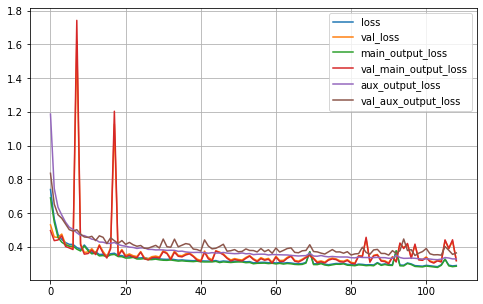

In [19]:
pd.DataFrame(history.history)[['loss', 'val_loss', 'main_output_loss', 'val_main_output_loss', 'aux_output_loss', 'val_aux_output_loss']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

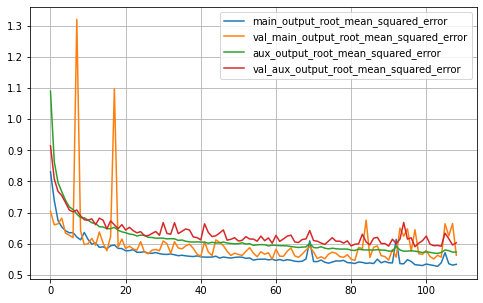

In [20]:
pd.DataFrame(history.history)[['main_output_root_mean_squared_error', 'val_main_output_root_mean_squared_error', 'aux_output_root_mean_squared_error', 'val_aux_output_root_mean_squared_error']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

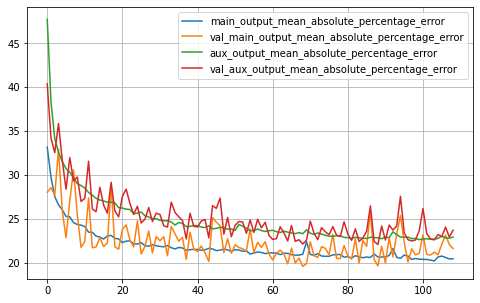

In [21]:
pd.DataFrame(history.history)[['main_output_mean_absolute_percentage_error', 'val_main_output_mean_absolute_percentage_error', 'aux_output_mean_absolute_percentage_error', 'val_aux_output_mean_absolute_percentage_error']].plot(figsize=(8,5))
plt.grid(True)
plt.show()

## Evaluate the model

In [22]:
mse_test = model.evaluate(
    {'wide_input': X_test_A, 'deep_input': X_test_B},
    {'main_output': y_test, 'aux_output': y_test}
)

162/162 [==============================] - 0s 504us/step - loss: nan - main_output_loss: nan - aux_output_loss: nan - main_output_root_mean_squared_error: nan - main_output_mean_absolute_percentage_error: nan - aux_output_root_mean_squared_error: nan - aux_output_mean_absolute_percentage_error: nan


## Call TensorBoard

We can call TensorBoard directly from the Jupyter notebook:

In [23]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 10524), started 0:09:20 ago. (Use '!kill 10524' to kill it.)

Alternatively, we can call TensorBoard via the shell by using the command<br>`tensorboard --logdir=./my_logs --port=6006`

In both cases, the TensorBoard dashboard can then be used via by accessing [http://localhost:6006/](http://localhost:6006/).